<a href="https://colab.research.google.com/github/KrsNovita2717/FaceExpressionDetection/blob/main/FaceExpressionDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Import library yang dibutuhkan
import cv2
import numpy as np
import os
import zipfile
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from google.colab import files

In [5]:
# Ekstraksi dataset
local_zip = '/content/drive/MyDrive/FER/FER.zip'
#local_zip = '/content/face-expression-recognition-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/FER')
zip_ref.close()

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Fungsi untuk memuat data
def load_data(path):
    x = []
    y = []
    labels = []
    folderList = os.listdir(path)
    folderList.sort()

    for i, category in enumerate(folderList):
        files = os.listdir(os.path.join(path, category))
        for file in files:
            img = cv2.imread(os.path.join(path, category, file), 0)
            x.append(img)
            y.append(i)
            labels.append(category)
    labels = np.array(labels)
    return np.array(x, 'float32') / 255.0, to_categorical(np.array(y), num_classes=7), labels

In [8]:
base_dir = '/content/FER/images'

train_dir = os.path.join(base_dir, 'images/train')
valid_dir = os.path.join(base_dir, 'images/validation')

# Memuat data train
x_train, y_train, train_labels = load_data(train_dir)
print("Jumlah data train:", len(x_train))

# Memuat data validation
x_valid, y_valid, valid_labels = load_data(valid_dir)
print("Jumlah data validation:", len(x_valid))

Jumlah data train: 28821
Jumlah data validation: 7066


In [9]:
# Reshape data train dan validation
x_train = x_train.reshape(x_train.shape[0], 48, 48, 1)
x_valid = x_valid.reshape(x_valid.shape[0], 48, 48, 1)

In [10]:
# Augmentasi gambar
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_datagen.fit(x_train)

In [11]:
# Membangun model CNN
model = Sequential([
    Conv2D(64, (3,3), padding="same", activation="relu", input_shape=(48, 48, 1)),
    Conv2D(64, (3,3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),

    Conv2D(128, (3,3), padding="same", activation="relu"),
    Conv2D(128, (3,3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),

    Conv2D(256, (3,3), padding="same", activation="relu"),
    Conv2D(256, (3,3), padding="same", activation="relu"),
    Conv2D(256, (3,3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),

    Conv2D(512, (3,3), padding="same", activation="relu"),
    Conv2D(512, (3,3), padding="same", activation="relu"),
    Conv2D(512, (3,3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),

    Conv2D(512, (3,3), padding="same", activation="relu"),
    Conv2D(512, (3,3), padding="same", activation="relu"),
    Conv2D(512, (3,3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),

    Flatten(),
    Dense(4096, activation="relu"),
    Dropout(0.5),
    Dense(4096, activation="relu"),
    Dense(7, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 128)       0         
 g2D)                                                   

In [12]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [13]:
# Latih model
batch_size = 32
epochs = 100

history = model.fit(
    train_datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(x_train) // batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_valid, y_valid)
)

Epoch 1/100
900/900 [==============================] - 64s 56ms/step - loss: 1.8185 - accuracy: 0.2476 - val_loss: 1.8110 - val_accuracy: 0.2583
Epoch 2/100
900/900 [==============================] - 49s 55ms/step - loss: 1.8131 - accuracy: 0.2486 - val_loss: 1.8113 - val_accuracy: 0.2583
Epoch 3/100
900/900 [==============================] - 47s 52ms/step - loss: 1.8092 - accuracy: 0.2486 - val_loss: 1.7975 - val_accuracy: 0.2583
Epoch 4/100
900/900 [==============================] - 49s 54ms/step - loss: 1.7971 - accuracy: 0.2497 - val_loss: 1.7810 - val_accuracy: 0.2622
Epoch 5/100
900/900 [==============================] - 47s 52ms/step - loss: 1.7883 - accuracy: 0.2527 - val_loss: 1.7709 - val_accuracy: 0.2804
Epoch 6/100
900/900 [==============================] - 47s 52ms/step - loss: 1.7818 - accuracy: 0.2580 - val_loss: 1.7520 - val_accuracy: 0.2913
Epoch 7/100
900/900 [==============================] - 49s 55ms/step - loss: 1.7514 - accuracy: 0.2807 - val_loss: 1.7442 - val_ac

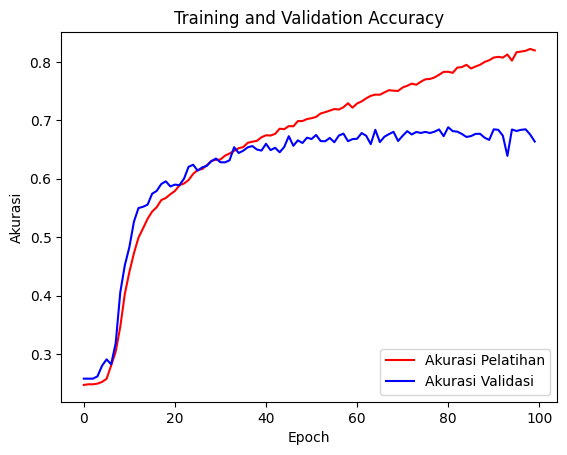

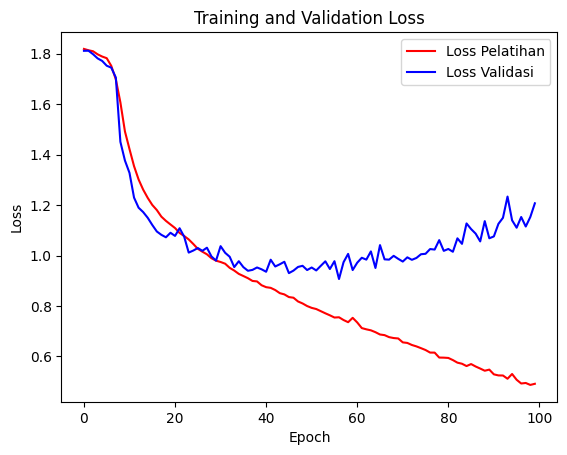

In [14]:
# Tampilkan grafik akurasi dan loss
plt.plot(history.history['accuracy'], 'r', label='Akurasi Pelatihan')
plt.plot(history.history['val_accuracy'], 'b', label='Akurasi Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.title("Training and Validation Accuracy")
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], 'r', label='Loss Pelatihan')
plt.plot(history.history['val_loss'], 'b', label='Loss Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Training and Validation Loss")
plt.legend(loc='upper right')
plt.show()

Saving images.jpeg to images.jpeg
1/1 [==============================] - 1s 786ms/step
Hasil prediksi: surprise


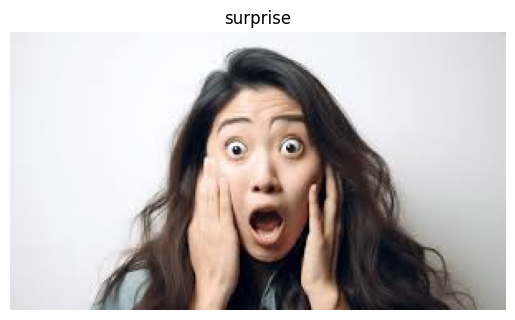

In [15]:
# Dictionary korespondensi label kelas dan nama folder
label_to_class = {0: "angry", 1: "disgust", 2: "fear", 3: "happy", 4: "neutral", 5: "sad", 6: "surprise"}

# Upload gambar untuk pengujian
uploaded = files.upload()

for filename in uploaded.keys():
    path = '/content/' + filename
    img = cv2.imread(path, 0)
    img = cv2.resize(img, (48, 48))
    img = np.array(img, 'float32') / 255.0
    img = img.reshape(1, 48, 48, 1)
    prediction = model.predict(img)
    label = np.argmax(prediction)
    predicted_class = label_to_class[label]
    print("Hasil prediksi:", predicted_class)

    # Tampilkan gambar
    plt.imshow(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB))  # Konversi ke format RGB
    plt.title(predicted_class)  # Judul gambar sesuai dengan hasil prediksi
    plt.axis('off')  # Hilangkan sumbu x dan y
    plt.show()


In [16]:
from google.colab import drive
model.save("FaceExpressionDetection.h5")
model.save("FaceExpressionDetection.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
!ls
from google.colab import files
files.download('FaceExpressionDetection.h5')

drive  FaceExpressionDetection.h5  FaceExpressionDetection.keras  FER  images.jpeg  sample_data


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>